# Diabetes Prediction using Linear Regression and KNN Regressor

This notebook predicts diabetes diagnosis using Linear Regression and KNN Regressor.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None) 



## 1. Load data


In [2]:
df = pd.read_csv('data/Diabetes_and_LifeStyle_Dataset .csv')


## Handling Missing DAta

In [3]:


print("Total missing values:", df.isnull().sum().sum())

print(f"\nMissing values per column:\n{df.isnull().sum()[df.isnull().sum() > 0]}")



Total missing values: 0

Missing values per column:
Series([], dtype: int64)


## 2. Data Preprocessing


In [4]:

leakage_features = [
    'diagnosed_diabetes',  
    'income_level', 
    'diabetes_risk_score',
    'hba1c',  
    'ethnicity',
    'diet_score',
    'waist_to_hip_ratio',
    'glucose_fasting',  
    'diabetes_stage'
    
]

X = df.drop(leakage_features, axis=1)
y = df['diagnosed_diabetes']


categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")



Categorical columns (4): ['gender', 'education_level', 'employment_status', 'smoking_status']

Numerical columns (18): ['Age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_postprandial', 'insulin_level']


In [5]:
X = X.fillna(X.mode().iloc[0]) 
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())  

print("Missing values after handling:", X.isnull().sum().sum())



Missing values after handling: 0


In [6]:
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

print("\nCategorical encoding completed!")


gender: 3 unique values
education_level: 4 unique values
employment_status: 4 unique values
smoking_status: 3 unique values

Categorical encoding completed!


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")


Training set shape: (77837, 22)
Test set shape: (19460, 22)

Training target distribution:
diagnosed_diabetes
1    46705
0    31132
Name: count, dtype: int64

Test target distribution:
diagnosed_diabetes
1    11677
0     7783
Name: count, dtype: int64


In [8]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)




## 3. Model Training and Evaluation

### 3.1 Linear Regression

In [9]:


lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

lr_train_binary = (lr_train_pred >= 0.5).astype(int)
lr_test_binary = (lr_test_pred >= 0.5).astype(int)

lr_train_accuracy = accuracy_score(y_train, lr_train_binary)
lr_test_accuracy = accuracy_score(y_test, lr_test_binary)

print("Linear Regression Results (converted to classification):")
# print(f"Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Test Accuracy: {lr_test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, lr_test_binary, target_names=['No Diabetes', 'Diabetes']))


Linear Regression Results (converted to classification):
Test Accuracy: 0.8186

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.79      0.74      0.77      7783
    Diabetes       0.83      0.87      0.85     11677

    accuracy                           0.82     19460
   macro avg       0.81      0.81      0.81     19460
weighted avg       0.82      0.82      0.82     19460



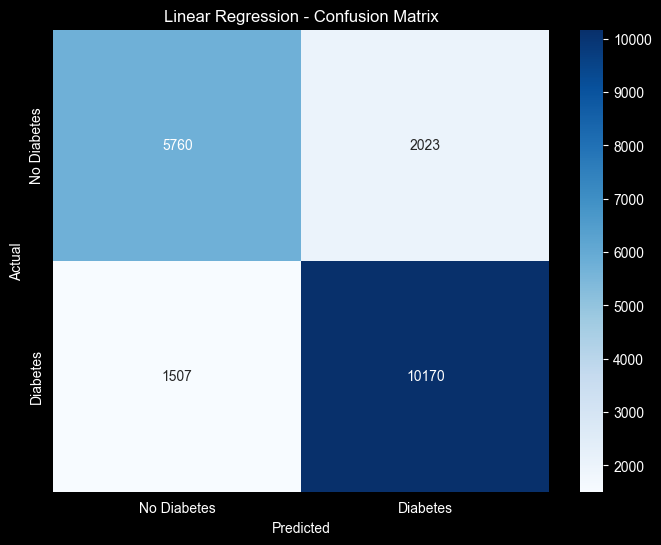

In [10]:
cm_lr = confusion_matrix(y_test, lr_test_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Linear Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3.2 KNN Regressor


In [11]:

knn_model = KNeighborsRegressor(n_neighbors=25, weights='uniform')
knn_model.fit(X_train_scaled, y_train)


knn_train_pred_continuous = knn_model.predict(X_train_scaled)
knn_test_pred_continuous = knn_model.predict(X_test_scaled)


knn_train_pred = (knn_train_pred_continuous >= 0.5).astype(int)
knn_test_pred = (knn_test_pred_continuous >= 0.5).astype(int)


knn_train_mse = mean_squared_error(y_train, knn_train_pred_continuous)
knn_test_mse = mean_squared_error(y_test, knn_test_pred_continuous)
knn_train_r2 = r2_score(y_train, knn_train_pred_continuous)
knn_test_r2 = r2_score(y_test, knn_test_pred_continuous)

knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)

print("KNN Regressor Results (n_neighbors=25, weights='uniform'):")
print(f"\nRegression Metrics:")
print(f"Training MSE: {knn_train_mse:.4f}")
print(f"Test MSE: {knn_test_mse:.4f}")
print(f"Training R²: {knn_train_r2:.4f}")
print(f"Test R²: {knn_test_r2:.4f}")
print(f"\nClassification Metrics (after thresholding at 0.5):")
print(f"Training Accuracy: {knn_train_accuracy:.4f}")
print(f"Test Accuracy: {knn_test_accuracy:.4f}")
print(f"Overfitting gap: {knn_train_accuracy - knn_test_accuracy:.4f}")
if knn_train_accuracy - knn_test_accuracy > 0.1:
    print("Warning: Still showing some overfitting")
print("\nClassification Report:")
print(classification_report(y_test, knn_test_pred, target_names=['No Diabetes', 'Diabetes']))


KNN Regressor Results (n_neighbors=25, weights='uniform'):

Regression Metrics:
Training MSE: 0.1413
Test MSE: 0.1540
Training R²: 0.4111
Test R²: 0.3584

Classification Metrics (after thresholding at 0.5):
Training Accuracy: 0.8066
Test Accuracy: 0.7814
Overfitting gap: 0.0252

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.76      0.67      0.71      7783
    Diabetes       0.79      0.86      0.82     11677

    accuracy                           0.78     19460
   macro avg       0.78      0.76      0.77     19460
weighted avg       0.78      0.78      0.78     19460



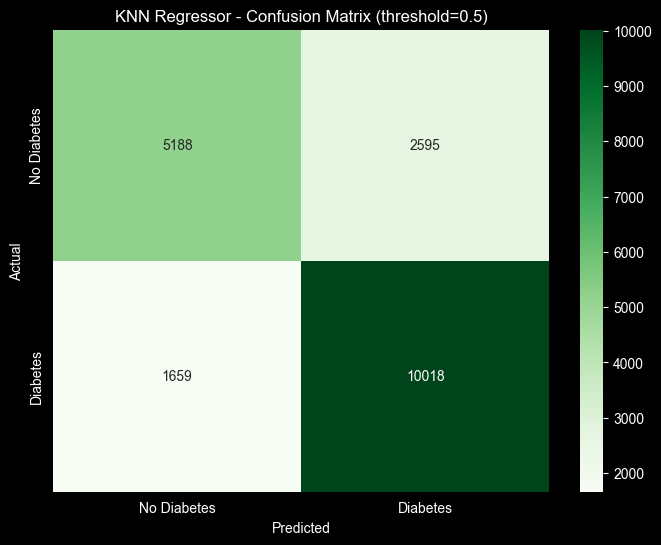

In [12]:

cm_knn = confusion_matrix(y_test, knn_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('KNN Regressor - Confusion Matrix (threshold=0.5)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 4. Model Comparison


Model Comparison:
               Model  Training Accuracy  Test Accuracy
0  Linear Regression           0.818852       0.818602
1      KNN Regressor           0.806622       0.781398


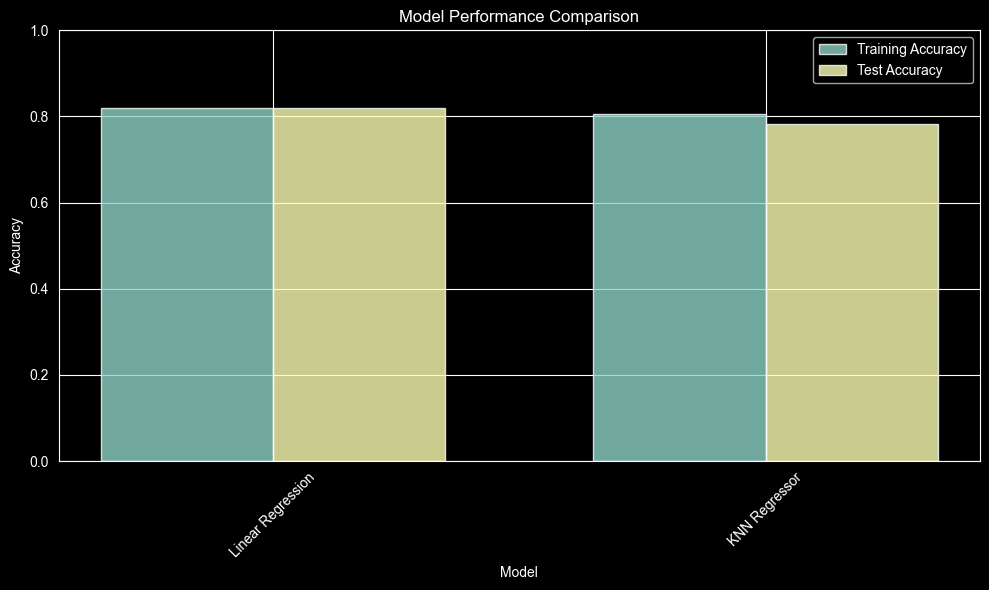

In [13]:

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor'],
    'Training Accuracy': [lr_train_accuracy, knn_train_accuracy],
    'Test Accuracy': [lr_test_accuracy, knn_test_accuracy]
})

print("Model Comparison:")
print(comparison)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison['Model']))
width = 0.35

ax.bar(x - width/2, comparison['Training Accuracy'], width, label='Training Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison['Test Accuracy'], width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.set_ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Loss Curve**

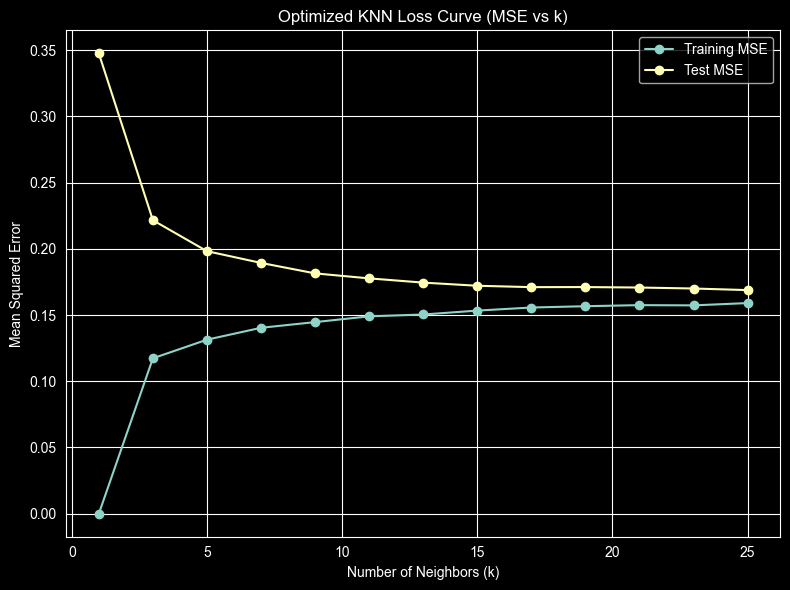

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Use a reduced sample for speed (optional, but keeps the curve accurate)
sample_size = 2000
if X_train_scaled.shape[0] > sample_size:
    X_train_small = X_train_scaled.sample(sample_size, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]
    X_test_small = X_test_scaled.sample(sample_size, random_state=42)
    y_test_small = y_test.loc[X_test_small.index]
else:
    X_train_small, y_train_small = X_train_scaled, y_train
    X_test_small, y_test_small = X_test_scaled, y_test

# Use only odd k values up to 25 for speed
k_values = list(range(1, 26, 2))
train_mse = []
test_mse = []

# Precompute the distance once (algorithm='brute', metric='euclidean' is fastest for small samples)
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform', algorithm='brute', metric='euclidean')
    knn.fit(X_train_small, y_train_small)

    train_pred = knn.predict(X_train_small)
    test_pred = knn.predict(X_test_small)

    train_mse.append(mean_squared_error(y_train_small, train_pred))
    test_mse.append(mean_squared_error(y_test_small, test_pred))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, train_mse, label='Training MSE', marker='o')
plt.plot(k_values, test_mse, label='Test MSE', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('Optimized KNN Loss Curve (MSE vs k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **ROC comparative graph**


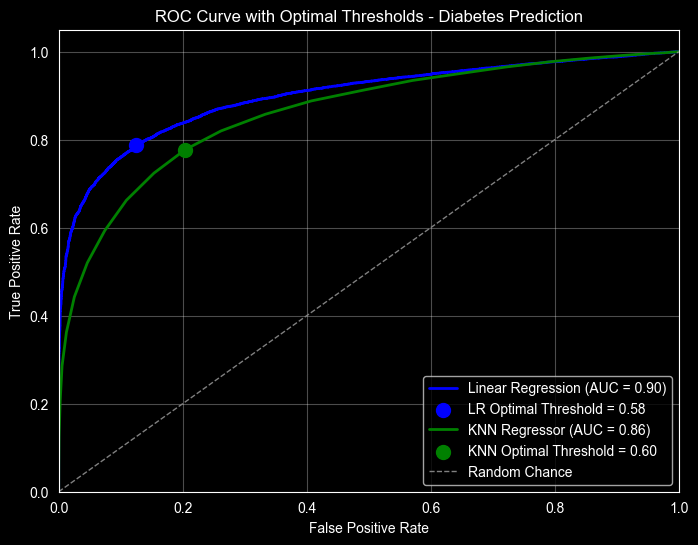

In [15]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# --- Linear Regression ROC ---
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_test_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Find optimal threshold (closest to top-left)
optimal_idx_lr = np.argmax(tpr_lr - fpr_lr)
optimal_threshold_lr = thresholds_lr[optimal_idx_lr]

# --- KNN Regressor ROC ---
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_test_pred_continuous)
roc_auc_knn = auc(fpr_knn, tpr_knn)

optimal_idx_knn = np.argmax(tpr_knn - fpr_knn)
optimal_threshold_knn = thresholds_knn[optimal_idx_knn]

# --- Plotting ROC Curves ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Linear Regression (AUC = {roc_auc_lr:.2f})')
plt.scatter(fpr_lr[optimal_idx_lr], tpr_lr[optimal_idx_lr], color='blue', marker='o', s=100,
            label=f'LR Optimal Threshold = {optimal_threshold_lr:.2f}')

plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN Regressor (AUC = {roc_auc_knn:.2f})')
plt.scatter(fpr_knn[optimal_idx_knn], tpr_knn[optimal_idx_knn], color='green', marker='o', s=100,
            label=f'KNN Optimal Threshold = {optimal_threshold_knn:.2f}')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Thresholds - Diabetes Prediction')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
